# Algoritmos de Histograma de Gradientes Orientados (HOG) de Dalal y Triggs

## Librerias

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy.signal import correlate2d

## Ejercicio 1

Implementar una función en Python que acepte una imagen a colores, y haga las siguientes transformaciones: 
- Conversión de RGB a escala de grises
- Reescalado (*resize*) a un tamaño (*128k,64k*), (ratio 2:1). 

En este caso **k ≥ 1** es un parámetro de escala que da el tamaño de la imagen de salida, y debe ser indicado por el usuario. La salida debe ser una imagen en formato 8 bits o float de tamaño (*128k, 64k*), esto es un numpy array de tamaño (*128k,64k*).

In [2]:
def preprocess_image(image, k=1):
    """
    Carga y preprocesa una imagen desde la ruta especificada.
    La imagen se convierte a escala de grises y se redimensiona a un tamaño específico.
    El tamaño de la imagen resultante es (128k, 64k) donde k es un factor de escala.
    
    Args:
        image (numpy.ndarray): Imagen de entrada en formato RGB.
        k (int): Factor de escala para redimensionar la imagen. Por defecto es 1.

    Returns:
        numpy.ndarray: Imagen preprocesada en formato float32.
    """
    try:
        
        # Verificar que k sea válido
        if k < 1:
            raise ValueError("k debe ser mayor o igual a 1")

        # Convertir a escala de grises
        gray_image = rgb2gray(image)  # devuelve una imagen en float64 [0, 1]

        # Redimensionar la imagen al tamaño (128k, 64k)
        new_size = (64 * k, 128 * k)  # (ancho, alto)
        resized_image = cv2.resize(gray_image, new_size, interpolation=cv2.INTER_AREA) # Cambiar el orden a (alto, ancho)

        # Convertir a float32 si se desea trabajar en precisión simple
        return resized_image.astype(np.float32)
   
    except Exception as e:
        print(f"ERROR | {e}")
        return None

### Prueba

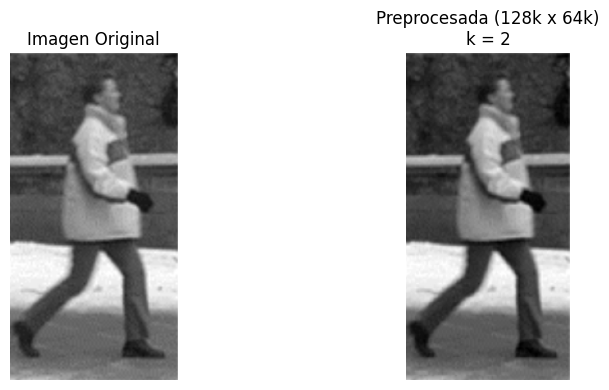

Imagen preprocesada de tamaño: (256, 128)


In [3]:
image = cv2.imread("Images/person.png") # Cargar la imagen

k = 2  # Factor de escala

processed = preprocess_image(image, k) # Preprocesar la imagen

# Mostrar la imagen original y la preprocesada
plt.figure(figsize=(10, 4))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(image)
plt.axis('off')

# Mostrar la imagen preprocesada
plt.subplot(1, 2, 2)
plt.title(f'Preprocesada (128k x 64k)\nk = {k}')
plt.imshow(processed, cmap='gray')
plt.axis('off')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()
plt.show()

print(f"Imagen preprocesada de tamaño: {processed.shape}")

## Ejercicio 2

Implementar una función en Python que calcule la **magnitud** y el **ángulo** del gradiente de una imagen en escala de grises. Internamente su algoritmo debe calcular las correlaciones  
$$ G_x = I * \nabla_x $$

y 

$$ G_y = I * \nabla_y $$

de la imagen con los **filtros de Prewitt**

$$
\nabla_x = 
\begin{bmatrix}
-1 & -1 & -1 \\
\phantom{-}0 & \phantom{-}0 & \phantom{-}0 \\
\phantom{-}1 & \phantom{-}1 & \phantom{-}1
\end{bmatrix}
\qquad
\nabla_y = 
\begin{bmatrix}
-1 & \phantom{-}0 & \phantom{-}1 \\
-1 & \phantom{-}0 & \phantom{-}1 \\
-1 & \phantom{-}0 & \phantom{-}1
\end{bmatrix}
$$

**o filtros de Sobel**

$$
\nabla_x = 
\begin{bmatrix}
-1 & -2 & -1 \\
\phantom{-}0 & \phantom{-}0 & \phantom{-}0 \\
\phantom{-}1 & \phantom{-}2 & \phantom{-}1
\end{bmatrix}
\qquad
\nabla_y = 
\begin{bmatrix}
-1 & \phantom{-}0 & \phantom{-}1 \\
-2 & \phantom{-}0 & \phantom{-}2 \\
-1 & \phantom{-}0 & \phantom{-}1
\end{bmatrix}
$$

(No olvidar hacer un *padding* adecuado en la imagen a filtrar, y dar una salida del mismo tamaño de la imagen de entrada).

En este caso la entrada es una imagen en escala de grises *I*. La salida de la funcion deben de ser dos im ágenes *µ* y *θ* dadas por:


$$
\mu = \sqrt{G_x^2 + G_y^2}
$$ 

y

$$
\theta = \arctan2(-G_y, G_x) \cdot \left( \frac{180}{\pi} \right)
$$

ambas del mismo tamaño de la imagen de entrada *I*.

(Considerar que se debe hacer módulo 180 en la imagen *θ* para que el rango de los angulos obtenidos sea siempre 0 ≤ *θ* ≤ 180)

In [4]:
def compute_gradient(I, sobel=True):
    """
    Calcula la magnitud y ángulo del gradiente de una imagen en escala de grises.
    Utiliza filtros de Sobel o Prewitt según lo especificado.
    
    Args:
        I (numpy.ndarray): Imagen en escala de grises (float32 o float64).
        sobel (bool): True para usar Sobel, False para usar Prewitt.
    
    Returns:
        tuple: (magnitud μ, ángulo θ) ambos del mismo tamaño que I.
    """
    # Seleccionar el filtro según el parámetro 'sobel'
    if sobel:
        # Filtros de Sobel
        kernel_x = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])
        kernel_y = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]])
    else:
        # Filtros de Prewitt
        kernel_x = np.array([[-1, -1, -1],
                             [ 0,  0,  0],
                             [ 1,  1,  1]])
        kernel_y = np.array([[-1, 0, 1],
                             [-1, 0, 1],
                             [-1, 0, 1]])

    # Correlaciones con padding para mantener el tamaño
    Gx = correlate2d(I, kernel_x, mode='same', boundary='symm')
    Gy = correlate2d(I, kernel_y, mode='same', boundary='symm')

    # Magnitud del gradiente
    mu = np.sqrt(Gx ** 2 + Gy ** 2)

    # Ángulo en grados, normalizado a [0, 180)
    theta = np.arctan2(-Gy, Gx) * (180.0 / np.pi)
    theta = np.mod(theta, 180.0)

    # Retornar magnitud y ángulo como float32
    return mu.astype(np.float32), theta.astype(np.float32)


### Prueba

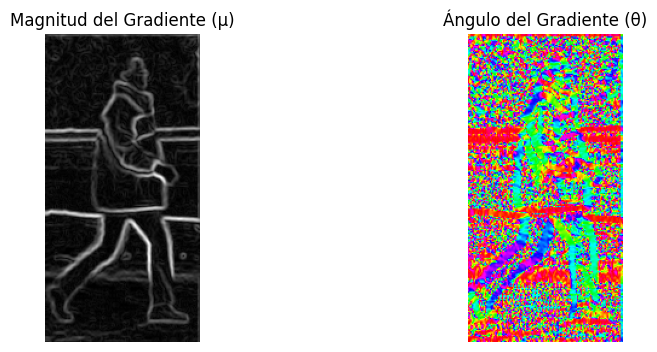

mu shape: (256, 128)
theta shape: (256, 128)


In [5]:
# Obtener la imagen preprocesada en escala de grises
gray_image = preprocess_image(image, k=k)

# Calcular gradientes
mu, theta = compute_gradient(gray_image, sobel=True)

# Visualizar
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Magnitud del Gradiente (μ)")
plt.imshow(mu, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Ángulo del Gradiente (θ)")
plt.imshow(theta, cmap='hsv')
plt.axis('off')
plt.show()

# Confirmar tamaños
print("mu shape:", mu.shape)
print("theta shape:", theta.shape)